# Feature Detector #

![](img/feature_simple.png)

- Red patch:   Corner (good feature, unique)
- Black patch: Edge (not unique)
- Blue patch:  Flat surface (bad feature)

## Harris corner detector ##

**+ Rotation invariant**

**- Not scale invariant**

Finds the difference in intensity for a displacement $(\Delta x,\Delta y)$ in all directions.

$$ E(x,y) = \sum_{x,y}w(x,y)[I(x+\Delta x, y+\Delta y) - I(x,y)]^2 $$

Where $w(x,y)$ is a rectangular or gaussian window, giving weights to underneath pixels.

This function has to be maximized for corner detection. Applying Taylor Expansion we have:

$$ E(x,y) \approx \begin{bmatrix}\Delta x&\Delta y\end{bmatrix} M \begin{bmatrix}\Delta x\\\Delta y\end{bmatrix}
\hspace{0.5cm} where \hspace{0.5cm}
M = \sum_{x,y}w(x,y)\begin{bmatrix} I_xI_x & I_xI_y \\ I_xI_y & I_yI_y \end{bmatrix} $$

M is a symetric matrix with real coefficients, so it can be diagonalized through an orthogonal transfer matrix.

$$ M=Q^{\mathsf{T}} D  Q$$

We can rotate $[\text{$\Delta $x},\text{$\Delta $y}]$ by $Q^{\mathsf{T}}$

$$Q^{\mathsf{T}} [\text{$\Delta $x},\text{$\Delta $y}]^{\mathsf{T}}=\left[\text{$\Delta $x}',\text{$\Delta $y}'\right]^{\mathsf{T}}$$

Giving: 

$$E(x,y)=\left[\text{$\Delta $x}',\text{$\Delta $y}'\right]D \left[\text{$\Delta $x}',\text{$\Delta $y}'\right]^{\mathsf{T}}=\lambda_1 \left(\text{$\Delta $x}'\right)^2+\lambda_2 \left(\text{$\Delta $y}'\right)^2$$

A score function was created to determines if a window can contain a corner or not:

$$ R = det(M) - k(trace(M))^2 = \lambda_1\lambda_2 - k(\lambda_1 + \lambda_2)^2 $$

- Region is flat:   $|R|$ is small, $\lambda_1$ and $\lambda_2$ are small.
- Region is edge:   $R<0$, $\lambda_1<<\lambda_2$ or $\lambda_2<<\lambda_1$.
- Region is corner: $\lambda_1$ and $\lambda_2$ are large or $\lambda_1 \sim \lambda_2$.

![](img/harris_region.jpg)

## Good Features to Track ##

$$ R = min(\lambda_1, \lambda_2)$$

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Test Image and its gradients


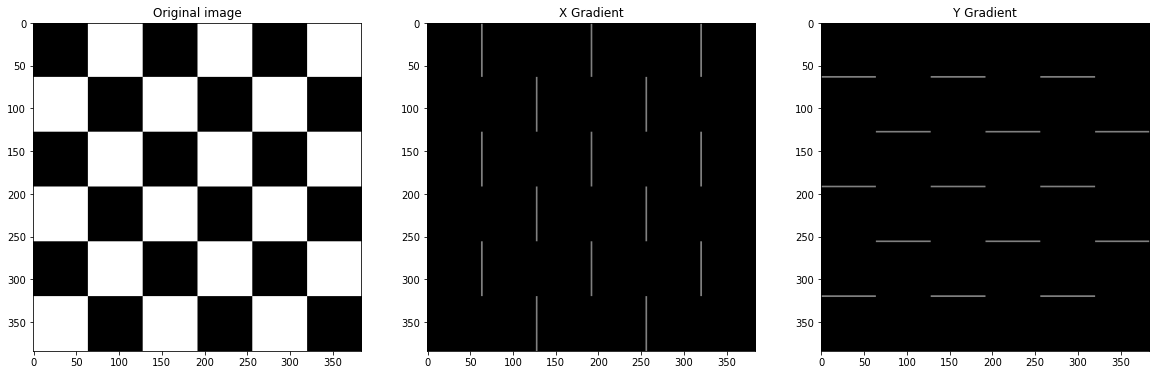

625 corners


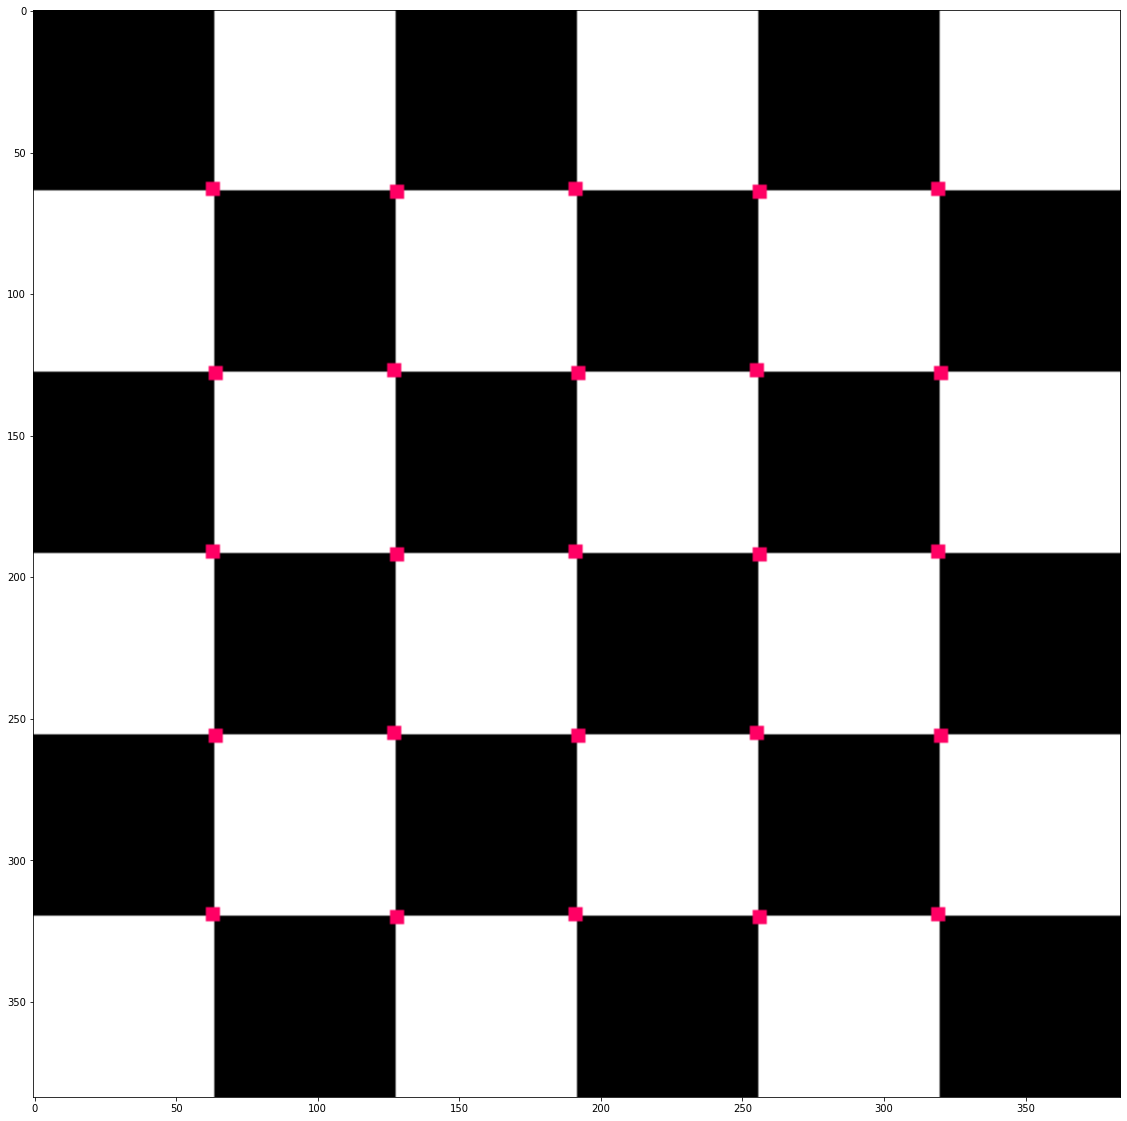

In [109]:
# image_file = "lena.png"
image_file = "checkerboard.png"

color_img = cv2.imread(image_file)
img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

# Test gradient
# img = np.zeros((512,512))
# img[255,:] = np.ones((512)) * 512
# img[:,255] = np.ones((512)) * 512

# process gradients
dy, dx = np.gradient(img)

# Show image
print("Test Image and its gradients")
plt.rcParams["figure.figsize"] = (20, 20)
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title("Original image")
plt.subplot(1,3,2)
plt.imshow(dx, cmap='gray', vmin=0, vmax=255)
plt.title("X Gradient")
plt.subplot(1,3,3)
plt.imshow(dy, cmap='gray', vmin=0, vmax=255)
plt.title("Y Gradient")
plt.show()

# Harris params
k = 0.04
thresh = 10**7 # 10**7
window_size = 5

Ixx = dx ** 2
Ixy = dy * dx
Iyy = dy ** 2
height = img.shape[0]
width = img.shape[1]

corners = []
offset = window_size // 2

# Main loop
for y in range(offset, height - offset):
    for x in range(offset, width - offset):
        # Calculate sum of squares
        windowIxx = Ixx[y - offset:y + offset + 1, x - offset:x + offset + 1]
        windowIxy = Ixy[y - offset:y + offset + 1, x - offset:x + offset + 1]
        windowIyy = Iyy[y - offset:y + offset + 1, x - offset:x + offset + 1]
        Sxx = windowIxx.sum()
        Sxy = windowIxy.sum()
        Syy = windowIyy.sum()

        # Find determinant and trace, use to get corner response
        det = (Sxx * Syy) - (Sxy ** 2)
        trace = Sxx + Syy
        r = det - k * (trace ** 2)

        # If corner response is over threshold, color the point and add to corner list
        if r > thresh:
            #print (x, y, r)
            corners.append([x, y, r])
            color_img.itemset((y, x, 2), 100)  #b
            color_img.itemset((y, x, 1), 0)    #g
            color_img.itemset((y, x, 0), 255)  #r

plt.imshow(color_img)
print(len(corners), "corners")

26 corners


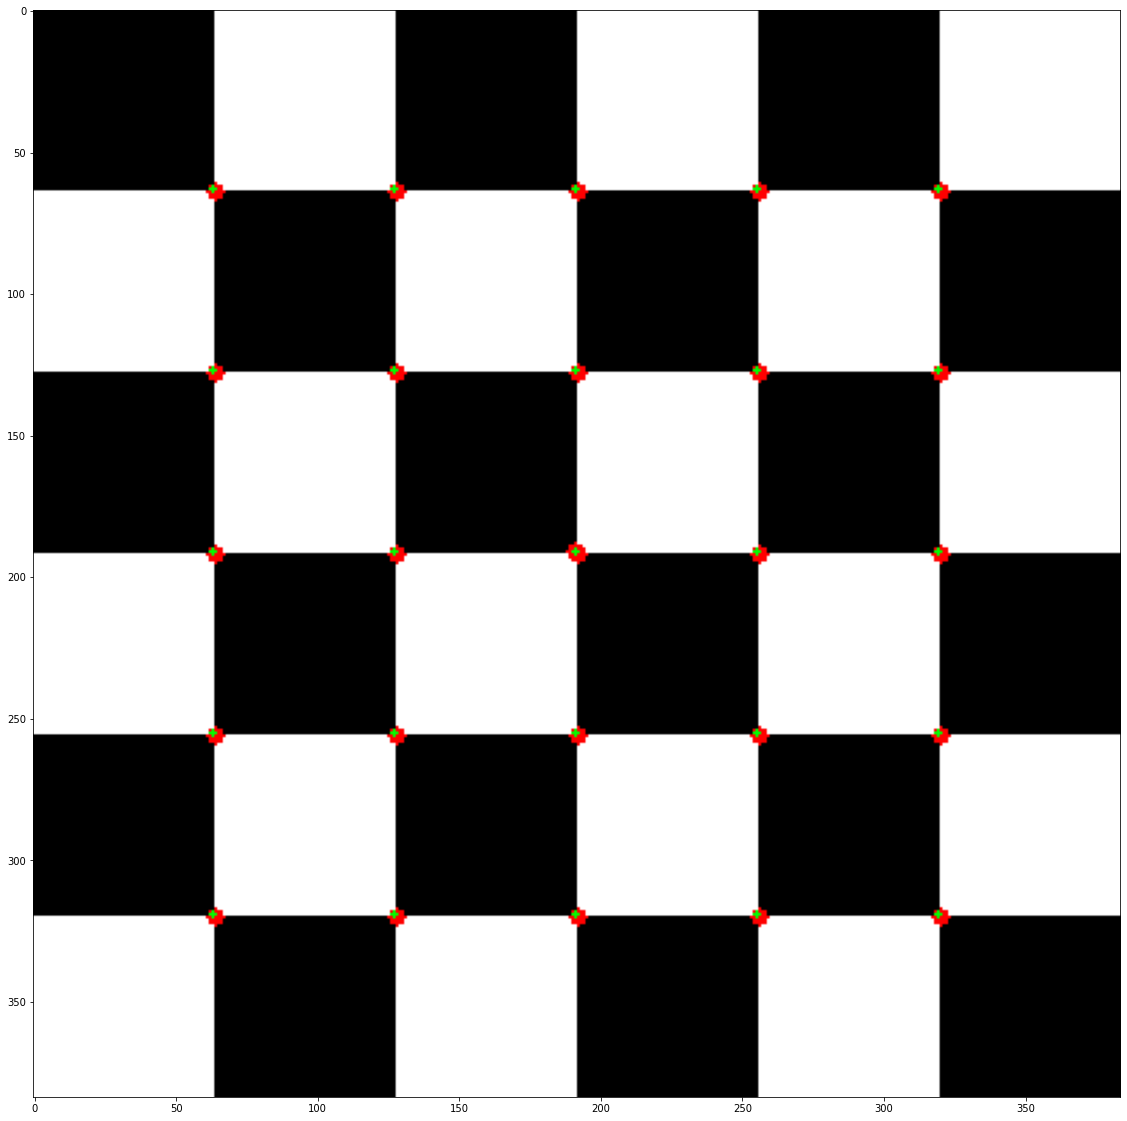

In [111]:
color_img = cv2.imread(image_file)
img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

# OpenCV Harris corners
gray = np.float32(img)
dst = cv2.cornerHarris(gray, 2, 3, k)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst, 0.01*dst.max(), 255, 0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
for r in res:
    x, y, vx, vy = r
    color_img = cv2.circle(color_img, (x,y), radius=3, color=(255, 0, 0), thickness=-1)
    color_img = cv2.circle(color_img, (vx,vy), radius=1, color=(0, 255, 0), thickness=-1)

plt.imshow(color_img)
print(len(res), "corners")

25 corners


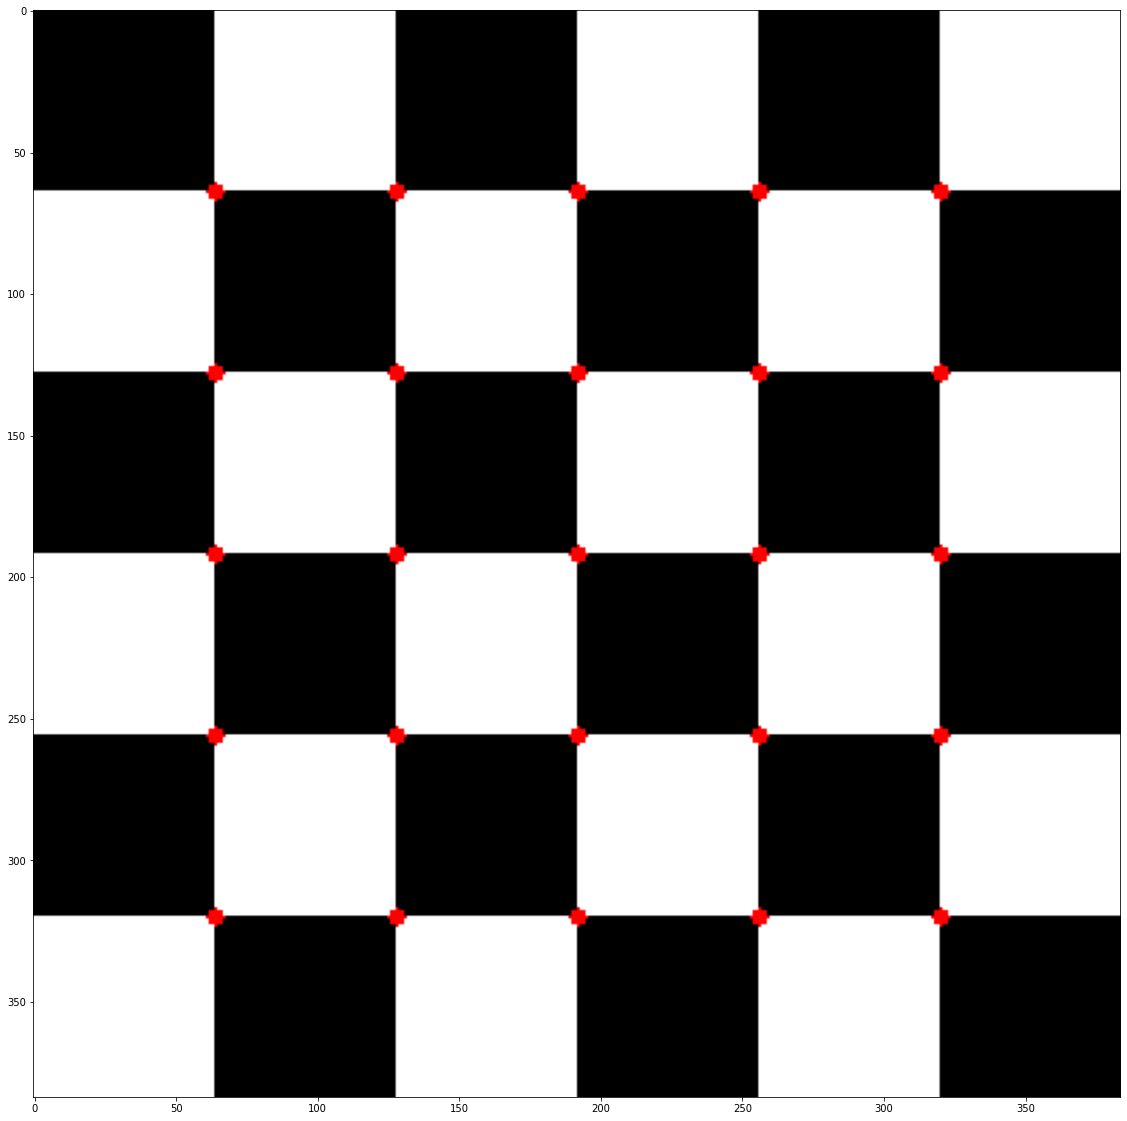

In [113]:
color_img = cv2.imread(image_file)
img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

# OpenCV Good Features to Track
corners = cv2.goodFeaturesToTrack(img,25,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(color_img,(x,y),3,255,-1)
    
plt.imshow(color_img)
print(len(corners), "corners")

## References ##

[1] "Understanding features", https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_meaning/py_features_meaning.html#features-meaning

[2] "Harris Corner Detection", https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html#harris-corners

[3] "Shi-Tomasi Corner Detector & Good Features to Track", https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html#shi-tomasi